# MNIST

In [6]:
# To avoid having to rerun everything.
retrain_model = False
rerun_grid = False
rerun_training_data = False

In [1]:
%matplotlib inline
import math
import random
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
import ddks
from sklearn import metrics
from sklearn.decomposition import PCA

import torchvision.transforms as T

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import time
import random
random.seed(1)

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from sklearn.model_selection import train_test_split

writer = SummaryWriter()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

False


In [7]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data/mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data/mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(mnist_train_loader.dataset)
TEST_SIZE = len(mnist_train_loader.dataset)
NUM_BATCHES = len(mnist_test_loader)
NUM_TEST_BATCHES = len(mnist_test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

inputs_mnist, classes_mnist = next(iter(mnist_train_loader))   

mnists = [a.reshape((28, 28)) for a in inputs_mnist]


mnist_test_loader_imgs = []
mnist_y_true_test = []
for X_batch, y_batch in mnist_test_loader:
    for x_j, y_j in zip(X_batch, y_batch):
        mnist_test_loader_imgs.append(x_j), mnist_y_true_test.append(y_j.detach().clone().numpy())
len(mnist_test_loader_imgs)


mnist_train_loader_imgs = []
mnist_y_true_train = []
for X_batch, y_batch in mnist_train_loader:
    for x_j, y_j in zip(X_batch, y_batch):
        mnist_train_loader_imgs.append(x_j), mnist_y_true_train.append(y_j.detach().clone().numpy())
len(mnist_train_loader_imgs)

60000

### x. BNN Model on MNIST

In [8]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()
    

class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()
    

# Visualizing scale mixture components
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])


class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)
    
    
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
    
    def forward(self, x, sample=False, return_pre=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x_pre = self.l3(x, sample)
        x = F.log_softmax(x_pre, dim=1)
        # Velger om man vil returnere pre activation neuron value
        if return_pre:
            return x, x_pre
        else:
            return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood
    

In [10]:
# Training:
if retrain_model:
    net_mnist = BayesianNetwork()
    def train(net, optimizer, epoch):
        net.train()
        for batch_idx, data, target in zip(range(len(X_train)), X_train, y_train):
            net.zero_grad()
            #print(data)
            loss = cancer_net.sample_elbo(X_train[0], y_train[0])
            loss.backward()
            optimizer.step()

    optimizer = optim.Adam(net_mnist.parameters())
    print("Start")
    for epoch in range(TRAIN_EPOCHS):
        train(net_mnist, optimizer, epoch)
        print(f"Epoch {epoch+1}/{TRAIN_EPOCHS}")
    print("Ferdig")


if not retrain_model:
    fileObj = open('../models/mnist/net_mnist.obj', 'rb')
    net_mnist = pickle.load(fileObj)
    fileObj.close()
    print(net_mnist)

BayesianNetwork(
  (l1): BayesianLinear()
  (l2): BayesianLinear()
  (l3): BayesianLinear()
)


### 1. Results loaded (Should ideally rerun these) 

In [16]:
class testing_framework:
    def __init__(self,
                 X_train_results):
        
        # Training data y_true, y_pred, entropy and pre-activations
        [#self.X_train_y_true,
         self.X_train_y_pred,
         self.X_train_entropy_1,
         self.X_train_preacts] = [#X_train_results[:, 0], 
                                  X_train_results[:, 0],
                                  X_train_results[:, 1],
                                  X_train_results[:, 2:]] 
        
   
        
        self.results = pd.DataFrame()
        self.FDR_results = pd.DataFrame()
        self.POWER_results = pd.DataFrame()
        self.ACC_results = pd.DataFrame()
        self.times = pd.DataFrame()
        self.ood_or_ib = pd.DataFrame()
        
    def new_test(self, 
                 pre_act_data,
                 entropy_data,
                 threshold_pre_act,
                 threshold_entropy,
                 entropy=True,
                 pre_act=True):
        # For storing results
        results = np.zeros(len(pre_act_data))
        # Number of pre-activation samples from training data
        len_X_train = len(self.X_train_preacts[:, 0])
        # Turn pre_activations from training data into absolute values
        train_samples_abs = self.X_train_preacts[:, 0]
        
        # For each test pre-activation test sample
        for idx, (pre_act_i, entropy_i) in enumerate(zip(pre_act_data, entropy_data)):
            
            # Absolute value of pre-activation test sample
            pre_act_i_abs = np.max(pre_act_i)
            #print(pre_act_i_abs)
            
            # Number of pre-activation values from training data the are over pre_act_i_abs 
           
            n_over = len(train_samples_abs[train_samples_abs > pre_act_i_abs])
            n_under = len(train_samples_abs[train_samples_abs < pre_act_i_abs])
            
            # Divide by number of pre-act values from training data
            self.test_statistic_1 = n_over/len_X_train
            self.test_statistic_2 = n_under/len_X_train
            
            # If test_statistic under given threshold, mark as outlier
            if entropy == True and pre_act == True:
                if  (self.test_statistic_1 < threshold_pre_act) or (self.test_statistic_2 < threshold_pre_act) or (entropy_i > threshold_entropy):
                    results[idx] = 1
            elif entropy == False and pre_act == True:
                if (self.test_statistic_1 < threshold_pre_act):
                    results[idx] = 1
                elif (self.test_statistic_2 < threshold_pre_act):
                    results[idx] = 2
            elif entropy == True and pre_act == False:
                if (entropy_i > threshold_entropy):
                    results[idx] = 1
            else:
                print("No method.")
                
                
        if entropy == True and pre_act == True:
            self.results[f"PRE-ACT_ENT"] = results
        elif entropy == False and pre_act == True:
            self.results[f"PRE-ACT"] = results
        elif entropy == True and pre_act == False:
            self.results[f"ENT"] = results
                    
        #self.results[f"new_test_pre_act={pre_act}__preactthreshold={threshold_pre_act}_entropy={entropy}_entropythreshold={threshold_entropy}"] = results
        return results
                
    
    @staticmethod
    def POWER_FDR(y_true_out, 
                  y_hatt_out, 
                  y_true_pred, 
                  y_hatt_pred):
        cm = metrics.confusion_matrix(y_true_out, 
                                      y_hatt_out)
        
        preds_true = []
        preds = []
        for y_i_true, y_i_hatt, out in zip(y_true_pred, y_hatt_pred, y_hatt_out):
            if out == 0:
                preds_true.append(y_i_true)
                preds.append(y_i_hatt)
            else:
                pass
                
        
        FP = cm[0, 1]
        TP = cm[0, 0]
        FN = cm[1, 0]
        TN = cm[1, 1]
                
        FDR = FP/(FP+TP)
        POWER = 1 - FN/(TP+FN)


        ACC = accuracy_score(preds_true, preds)

        return [POWER], [FDR], [ACC]
    
    def test_FDR_and_POWER(self, y_true_out, 
                           results_table, 
                           y_pred, 
                           y_hatt_pred):
        for col in results_table.columns:
            [self.POWER_results[col], 
            self.FDR_results[col],
            self.ACC_results[col]] = self.POWER_FDR(y_true_out, 
                                                    results_table[col],
                                                    y_pred, 
                                                    y_hatt_pred)
             
             
                
    def entropy(self, entropy_data, threshold=0.05):
        results = []
        for ent in entropy_data:
            if ent > threshold:
                results.append(1)
            else:
                results.append(0)
                
        self.results[f"entropy_thres:{threshold}"] = results

### 2. Testing

In [17]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data/mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data/mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(mnist_train_loader.dataset)
TEST_SIZE = len(mnist_train_loader.dataset)
NUM_BATCHES = len(mnist_test_loader)
NUM_TEST_BATCHES = len(mnist_test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

inputs_mnist, classes_mnist = next(iter(mnist_train_loader))   

mnists = [a.reshape((28, 28)) for a in inputs_mnist]


mnist_test_loader_imgs = []
mnist_y_true_test = []
for X_batch, y_batch in mnist_test_loader:
    for x_j, y_j in zip(X_batch, y_batch):
        mnist_test_loader_imgs.append(x_j), mnist_y_true_test.append(y_j.detach().clone().numpy())
len(mnist_test_loader_imgs)


mnist_train_loader_imgs = []
mnist_y_true_train = []
for X_batch, y_batch in mnist_train_loader:
    for x_j, y_j in zip(X_batch, y_batch):
        mnist_train_loader_imgs.append(x_j), mnist_y_true_train.append(y_j.detach().clone().numpy())
len(mnist_train_loader_imgs)

60000

In [18]:
def add_y_true(df_results, y_true):
    cols = ["y_pred", "entropy_1", "entropy_2", "max1", "max2", "max3", "max4", "max5", "max6", "max7", "max8", "max9", "max10"]
    cols_2 = ["y_true", "y_pred", "entropy_1", "entropy_2", "max1", "max2", "max3", "max4", "max5", "max6", "max7", "max8", "max9", "max10"]
    df_results.columns = cols
    df_results["y_true"] = y_true
    df_results = df_results[cols_2]
    return df_results
    


y_true = [int(i) for i in mnist_y_true_test]

mnist_train = add_y_true(pd.read_csv("../results/mnist/mnist_train_results_softmax.csv", index_col=0),
                        mnist_y_true_train)

mnist_test = add_y_true(pd.read_csv("../results/mnist/mnist_test_results_softmax.csv", index_col=0),
                        y_true)

fmnist_test = add_y_true(pd.read_csv("../results/mnist/fmnist_test_results_on_mnist_model_softmax.csv", index_col=0),
                        y_true)

blurred_test = add_y_true(pd.read_csv("../results/mnist/blurred_mnist_test_results_softmax.csv", index_col=0).iloc[:10000, :],
                        y_true)

constant_test = add_y_true(pd.read_csv("../results/mnist/constant_mnist_test_results_softmax.csv", index_col=0).iloc[:10000, :],
                        y_true)

inverted_test = add_y_true(pd.read_csv("../results/mnist/inverted_mnist_test_results_softmax.csv", index_col=0).iloc[:10000, :],
                        y_true)

shuffled_test = add_y_true(pd.read_csv("../results/mnist/shuffled_mnist_test_results_softmax.csv", index_col=0).iloc[:10000, :],
                        y_true)

partially_shuffled_test = add_y_true(pd.read_csv("../results/mnist/partially_shuffled_mnist_test_results_softmax.csv", index_col=0).iloc[:10000, :],
                        y_true)

In [19]:
mnist_train = pd.DataFrame(mnist_train).drop(columns=["entropy_2"]).to_numpy()[:, 1:]

#### 2.1 FMNIST

In [20]:
tr_sim_fmnist = testing_framework(mnist_train)
df_net_mnist = pd.concat([mnist_test, fmnist_test], ignore_index=True).drop(columns=["entropy_2"]).to_numpy()[:, 1:]

tr_sim_fmnist.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=False,
                pre_act=True)
    
tr_sim_fmnist.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=False)

tr_sim_fmnist.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=True)


tr_sim_fmnist.test_FDR_and_POWER([*np.zeros(1000), *np.ones(1000)], 
                            tr_sim_fmnist.results,
                            [*mnist_y_true_test[9000:], *[11 for _ in range(1000)]],
                            df_net_mnist[9000:11000, 0])

test_df_fmnist = pd.concat((tr_sim_fmnist.FDR_results, tr_sim_fmnist.POWER_results))
test_df_fmnist = pd.concat((test_df_fmnist, tr_sim_fmnist.ACC_results))

#### 2.2 Blurred MNIST

In [21]:
tr_sim_blurred = testing_framework(mnist_train)
df_net_mnist = pd.concat([mnist_test, blurred_test], ignore_index=True).drop(columns=["entropy_2"]).to_numpy()[:, 1:]

tr_sim_blurred.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=False,
                pre_act=True)
    
tr_sim_blurred.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=False)

tr_sim_blurred.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=True)


tr_sim_blurred.test_FDR_and_POWER([*np.zeros(1000), *np.ones(1000)], 
                            tr_sim_blurred.results,
                            [*mnist_y_true_test[9000:], *[11 for _ in range(1000)]],
                            df_net_mnist[9000:11000, 0])

test_df_blurred = pd.concat((tr_sim_blurred.FDR_results, tr_sim_blurred.POWER_results))
test_df_blurred = pd.concat((test_df_blurred, tr_sim_blurred.ACC_results))

#### 2.3 Inverted MNIST

In [22]:
tr_sim_inverted = testing_framework(mnist_train)
df_net_mnist = pd.concat([mnist_test, inverted_test], ignore_index=True).drop(columns=["entropy_2"]).to_numpy()[:, 1:]

tr_sim_inverted.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=False,
                pre_act=True)
    
tr_sim_inverted.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=False)

tr_sim_inverted.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=True)


tr_sim_inverted.test_FDR_and_POWER([*np.zeros(1000), *np.ones(1000)], 
                            tr_sim_inverted.results,
                            [*mnist_y_true_test[9000:], *[11 for _ in range(1000)]],
                            df_net_mnist[9000:11000, 0])

test_df_inverted = pd.concat((tr_sim_inverted.FDR_results, tr_sim_inverted.POWER_results))
test_df_inverted = pd.concat((test_df_inverted, tr_sim_inverted.ACC_results))

#### 2.4 Constant added to MNIST

In [23]:
tr_sim_constant = testing_framework(mnist_train)
df_net_mnist = pd.concat([mnist_test, constant_test], ignore_index=True).drop(columns=["entropy_2"]).to_numpy()[:, 1:]

tr_sim_constant.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=False,
                pre_act=True)
    
tr_sim_constant.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=False)

tr_sim_constant.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=True)


tr_sim_constant.test_FDR_and_POWER([*np.zeros(1000), *np.ones(1000)], 
                            tr_sim_constant.results,
                            [*mnist_y_true_test[9000:], *[11 for _ in range(1000)]],
                            df_net_mnist[9000:11000, 0])

test_df_constant = pd.concat((tr_sim_constant.FDR_results, tr_sim_constant.POWER_results))
test_df_constant = pd.concat((test_df_constant, tr_sim_constant.ACC_results))

#### 2.5 Shuffled pixels on MNIST

In [24]:
tr_sim_shuffled = testing_framework(mnist_train)
df_net_mnist = pd.concat([mnist_test, shuffled_test], ignore_index=True).drop(columns=["entropy_2"]).to_numpy()[:, 1:]

tr_sim_shuffled.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=False,
                pre_act=True)
    
tr_sim_shuffled.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=False)

tr_sim_shuffled.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=True)


tr_sim_shuffled.test_FDR_and_POWER([*np.zeros(1000), *np.ones(1000)], 
                            tr_sim_shuffled.results,
                            [*mnist_y_true_test[9000:], *[11 for _ in range(1000)]],
                            df_net_mnist[9000:11000, 0])

test_df_shuffled = pd.concat((tr_sim_shuffled.FDR_results, tr_sim_shuffled.POWER_results))
test_df_shuffled = pd.concat((test_df_shuffled, tr_sim_shuffled.ACC_results))

#### 2.6 Partially Shuffled pixels on MNIST

In [25]:
tr_sim_partially_shuffled = testing_framework(mnist_train)
df_net_mnist = pd.concat([mnist_test, partially_shuffled_test], ignore_index=True).drop(columns=["entropy_2"]).to_numpy()[:, 1:]

tr_sim_partially_shuffled.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=False,
                pre_act=True)
    
tr_sim_partially_shuffled.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=False)

tr_sim_partially_shuffled.new_test(df_net_mnist[9000:11000, 3],
                df_net_mnist[9000:11000, 1],
                0.05,
                0.6,
                entropy=True,
                pre_act=True)


tr_sim_partially_shuffled.test_FDR_and_POWER([*np.zeros(1000), *np.ones(1000)], 
                            tr_sim_partially_shuffled.results,
                            [*mnist_y_true_test[9000:], *[11 for _ in range(1000)]],
                            df_net_mnist[9000:11000, 0])

test_df_partially_shuffled = pd.concat((tr_sim_partially_shuffled.FDR_results, tr_sim_partially_shuffled.POWER_results))
test_df_partially_shuffled = pd.concat((test_df_partially_shuffled, tr_sim_partially_shuffled.ACC_results))

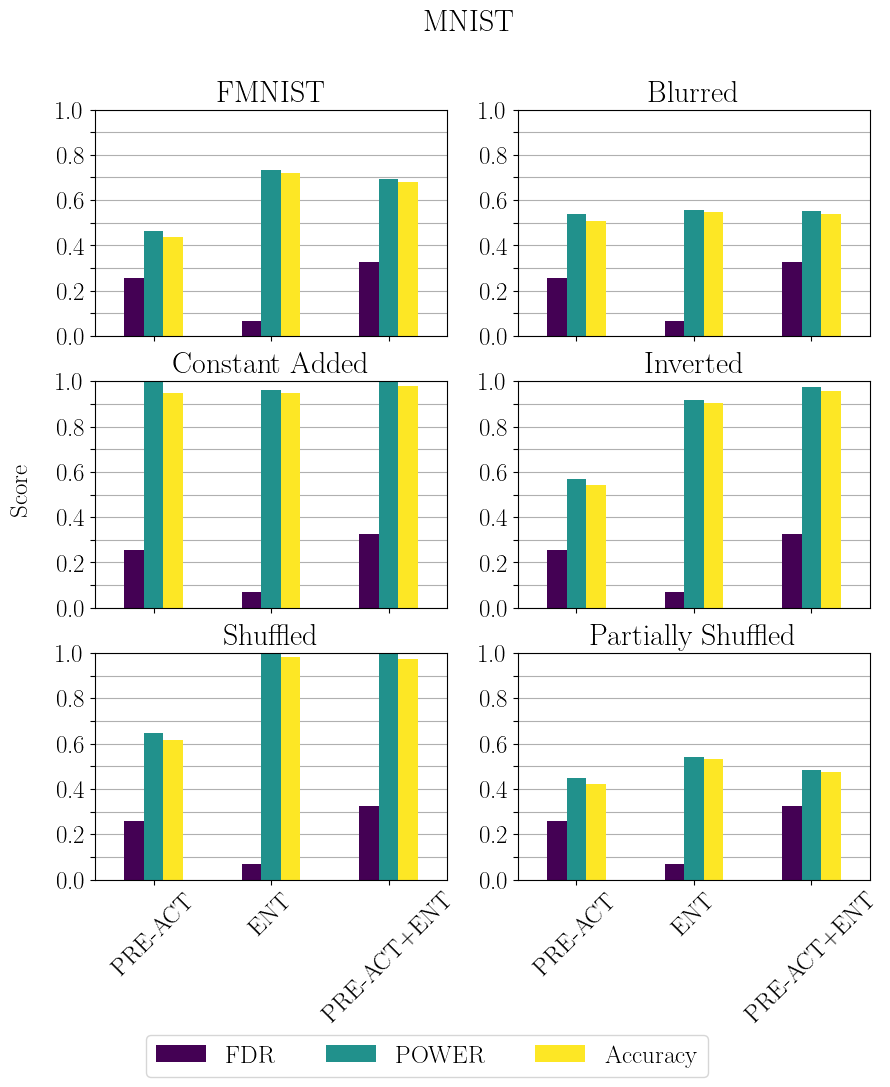

In [26]:
cmap="viridis"
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10, 10))
plt.suptitle("MNIST")
plt.set_cmap("viridis")


test_df_fmnist.T.plot.bar(title="FMNIST", ax=axes[0, 0], colormap=cmap)
#axes[0].legend(["FDR", "POWER", "Accuracy"])
#axes[0].set_xlabel("Method")
axes[0, 0].set_axisbelow(True)
axes[0, 0].grid(axis='y')
axes[0, 0].get_legend().remove()
axes[0, 0].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])


test_df_blurred.T.plot.bar(title="Blurred", ax=axes[0, 1], colormap=cmap)
#axes[0].legend(["FDR", "POWER", "Accuracy"])
#axes[0].set_xlabel("Method")
axes[0, 1].set_axisbelow(True)
axes[0, 1].grid(axis='y')
axes[0, 1].get_legend().remove()
axes[0, 1].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])


test_df_constant.T.plot.bar(title="Constant Added", ax=axes[1, 0], colormap=cmap)
#axes[0].legend(["FDR", "POWER", "Accuracy"])
#axes[0].set_xlabel("Method")
axes[1, 0].set_axisbelow(True)
axes[1, 0].grid(axis='y')
axes[1, 0].get_legend().remove()
axes[1, 0].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])



test_df_inverted.T.plot.bar(title="Inverted", ax=axes[1, 1], colormap=cmap)
#axes[0].legend(["FDR", "POWER", "Accuracy"])
#axes[0].set_xlabel("Method")
axes[1, 1].set_axisbelow(True)
axes[1, 1].grid(axis='y')
axes[1, 1].get_legend().remove()
axes[1, 1].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])


test_df_shuffled.T.plot.bar(title="Shuffled", ax=axes[2, 0], colormap=cmap)
#axes[0].legend(["FDR", "POWER", "Accuracy"])
#axes[0].set_xlabel("Method")
axes[2, 0].set_axisbelow(True)
axes[2, 0].grid(axis='y')
axes[2, 0].get_legend().remove()
axes[2, 0].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[2, 0].set_ylim(0, 1)
axes[2, 0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])



test_df_partially_shuffled.T.plot.bar(title="Partially Shuffled", ax=axes[2, 1], colormap=cmap)
#axes[0].legend(["FDR", "POWER", "Accuracy"])
#axes[0].set_xlabel("Method")
axes[2, 1].set_axisbelow(True)
axes[2, 1].grid(axis='y')
axes[2, 1].get_legend().remove()
#axes[2, 1].tick_params(labelrotation=45)
axes[2, 1].set_ylim(0, 1)
axes[2, 1].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[2, 1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])


#fig.text(0.5, -0.2, 'Method', ha='center')
fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

labels=["FDR", "POWER", "Accuracy"]
fig.legend(labels, loc='lower right', bbox_to_anchor=(0.75,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)


plt.show()

## PCA

In [27]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data/fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data/fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(mnist_train_loader.dataset)
TEST_SIZE = len(mnist_train_loader.dataset)
NUM_BATCHES = len(mnist_test_loader)
NUM_TEST_BATCHES = len(mnist_test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

inputs_mnist, classes_mnist = next(iter(mnist_train_loader))   

mnists = [a.reshape((28, 28)) for a in inputs_mnist]

mnist_test_loader_imgs = []
mnist_y_true_test = []
for X_batch, y_batch in mnist_test_loader:
    for x_j, y_j in zip(X_batch, y_batch):
        mnist_test_loader_imgs.append(x_j), mnist_y_true_test.append(y_j.detach().clone().numpy())
len(mnist_test_loader_imgs)

10000

In [28]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

fmnist_train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '../data/fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)
fmnist_test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '../data/fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(fmnist_train_loader.dataset)
TEST_SIZE = len(fmnist_train_loader.dataset)
NUM_BATCHES = len(fmnist_test_loader)
NUM_TEST_BATCHES = len(fmnist_test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

inputs_fmnist, classes_fmnist = next(iter(fmnist_train_loader))   

fmnists = [a.reshape((28, 28)) for a in inputs_fmnist]

fmnist_test_loader_imgs = []
fmnist_y_true_test = []
for X_batch, y_batch in fmnist_test_loader:
    for x_j, y_j in zip(X_batch, y_batch):
        fmnist_test_loader_imgs.append(x_j), fmnist_y_true_test.append(y_j.detach().clone().numpy())
len(fmnist_test_loader_imgs)

10000

In [29]:
# Transformed data:

# Blurred Images
blurrer = T.GaussianBlur(kernel_size=(5, 9), 
                         sigma=(0.1, 5))

blurred_imgs = [blurrer(a).reshape((28, 28)) for a in mnist_test_loader_imgs]

# Inverted Images
inverted_imgs = [T.functional.invert(a).reshape((28, 28)) for a in mnist_test_loader_imgs]

# Contant(1000) added Images
constant_added = [a.reshape((28, 28))+1000 for a in mnist_test_loader_imgs]

# Shuffled Pixels Images
flatt1 = [torch.flatten(t.detach().clone()).numpy() for t in mnist_test_loader_imgs]
[random.shuffle(c[:]) for c in flatt1]
flatt1 = [torch.from_numpy(a).reshape((28, 28)) for a in flatt1]

# Partially Shuffled Pixels Images
flatt2 = [torch.flatten(t.detach().clone()).numpy() for t in mnist_test_loader_imgs]
s=550
f=700

[random.shuffle(c[s:]) for c in flatt2]
flatt2 = [torch.from_numpy(a).reshape((28, 28)) for a in flatt2]

In [30]:
mnist_pca  = [b.detach().clone().numpy().flatten() for b in mnist_test_loader_imgs]
fmnist_pca  = [b.detach().clone().numpy().flatten() for b in fmnist_test_loader_imgs]
ca = np.array([*mnist_pca, *fmnist_pca]) 

pca = PCA(2) # we need 2 principal components.
converted_data_fmnist = pca.fit_transform(ca)

In [31]:
mnist_pca  = [b.detach().clone().numpy().flatten() for b in mnist_test_loader_imgs]
fmnist_pca  = [b.detach().clone().numpy().flatten() for b in inverted_imgs]
ca = np.array([*mnist_pca, *fmnist_pca]) 

pca = PCA(2) # we need 2 principal components.
converted_data_inverted = pca.fit_transform(ca)


In [32]:
mnist_pca  = [b.detach().clone().numpy().flatten() for b in mnist_test_loader_imgs]
fmnist_pca  = [b.detach().clone().numpy().flatten() for b in blurred_imgs]
ca = np.array([*mnist_pca, *fmnist_pca]) 

pca = PCA(2) # we need 2 principal components.
converted_data_blurred = pca.fit_transform(ca)

In [33]:
mnist_pca  = [b.detach().clone().numpy().flatten() for b in mnist_test_loader_imgs]
constant_pca  = [b.detach().clone().numpy().flatten() for b in constant_added]
ca = np.array([*mnist_pca, *constant_pca]) 

pca = PCA(2) # we need 2 principal components.
converted_data_constant = pca.fit_transform(ca)

In [34]:
mnist_pca  = [b.detach().clone().numpy().flatten() for b in mnist_test_loader_imgs]
fmnist_pca  = [b.detach().clone().numpy().flatten() for b in flatt1]
ca = np.array([*mnist_pca, *fmnist_pca]) 

pca = PCA(2) # we need 2 principal components.
converted_data_shuffled = pca.fit_transform(ca)

In [35]:
mnist_pca  = [b.detach().clone().numpy().flatten() for b in mnist_test_loader_imgs]
fmnist_pca  = [b.detach().clone().numpy().flatten() for b in flatt2]
ca = np.array([*mnist_pca, *fmnist_pca]) 

pca = PCA(2) # we need 2 principal components.
converted_data_partially_shuffled = pca.fit_transform(ca)

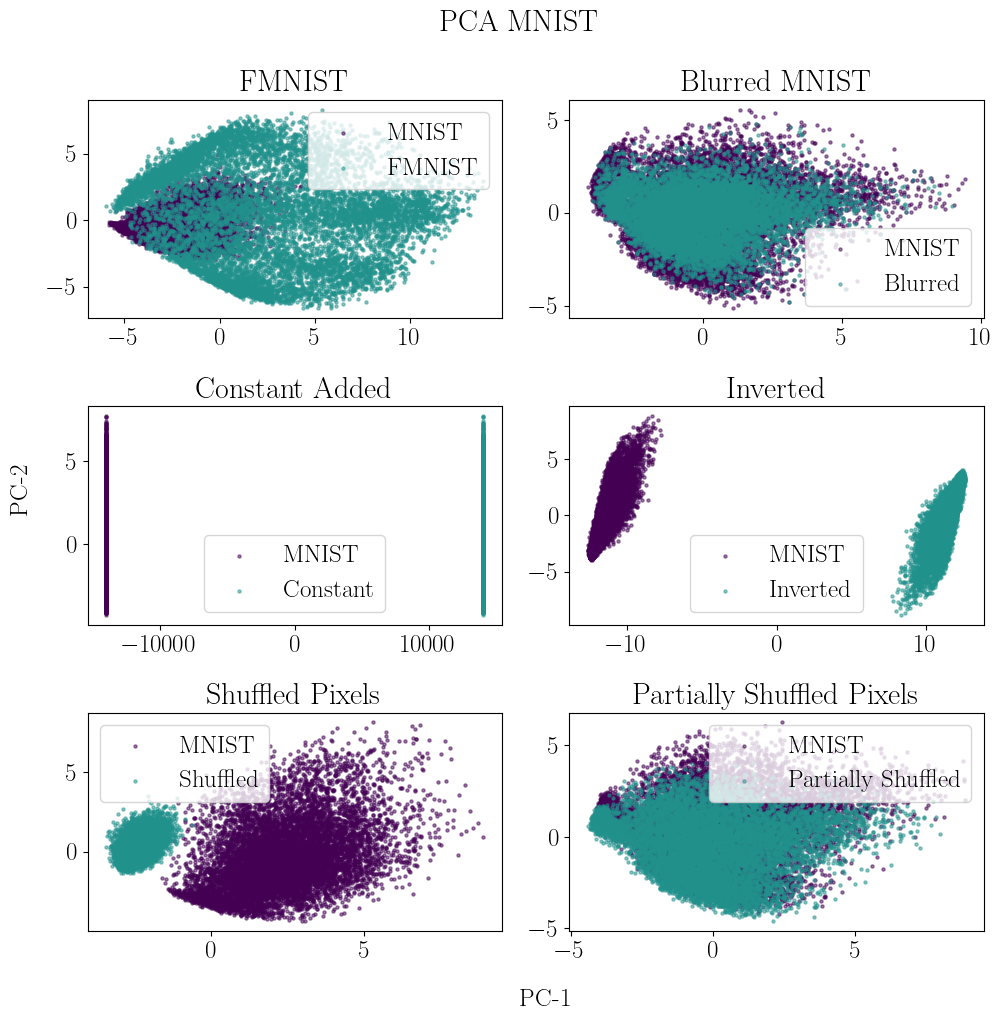

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.suptitle("PCA MNIST")


mnist_pca  = [b.detach().clone().numpy().flatten() for b in mnist_test_loader_imgs]
fmnist_pca  = [b.detach().clone().numpy().flatten() for b in fmnist_test_loader_imgs]
ca = np.array([*mnist_pca, *fmnist_pca]) 

pca = PCA(2) # we need 2 principal components.
converted_data_mnist = pca.fit_transform(ca)

# "#440154" "#21918c"

axes[0, 0].scatter(converted_data_fmnist[:10000, 0], converted_data_fmnist[:10000, 1], s = 5, c = "#440154", label="MNIST", alpha=0.5)
axes[0, 0].scatter(converted_data_fmnist[10000:20000, 0], converted_data_fmnist[10000:20000, 1], s = 5, c = "#21918c", label="FMNIST", alpha=0.5) #, *constant_l]
axes[0, 0].set_title("FMNIST")
axes[0, 0].legend(["MNIST", "FMNIST"], frameon=True)

axes[0, 1].scatter(converted_data_blurred[:10000, 0], converted_data_blurred[:10000, 1], s = 5, c = "#440154", label="MNIST", alpha=0.5)
axes[0, 1].scatter(converted_data_blurred[10000:20000, 0], converted_data_blurred[10000:20000, 1], s = 5, c = "#21918c", label="FMNIST", alpha=0.5) #, *constant_l]
axes[0, 1].set_title("Blurred MNIST")
axes[0, 1].legend(["MNIST", "Blurred"], frameon=True)

axes[1, 0].scatter(converted_data_constant[:10000, 0], converted_data_constant[:10000, 1], s = 5, c = "#440154", label="MNIST", alpha=0.5)
axes[1, 0].scatter(converted_data_constant[10000:20000, 0], converted_data_constant[10000:20000, 1], s = 5, c = "#21918c", label="FMNIST", alpha=0.5) #, *constant_l]
axes[1, 0].set_title("Constant Added")
axes[1, 0].legend(["MNIST", "Constant"], frameon=True)

axes[1, 1].scatter(converted_data_inverted[:10000, 0], converted_data_inverted[:10000, 1], s = 5, c = "#440154", label="MNIST", alpha=0.5)
axes[1, 1].scatter(converted_data_inverted[10000:20000, 0], converted_data_inverted[10000:20000, 1], s = 5, c = "#21918c", label="FMNIST", alpha=0.5) #, *constant_l]
axes[1, 1].set_title("Inverted")
axes[1, 1].legend(["MNIST", "Inverted"], frameon=True)

axes[2, 0].scatter(converted_data_shuffled[:10000, 0], converted_data_shuffled[:10000, 1], s = 5, c = "#440154", label="MNIST", alpha=0.5)
axes[2, 0].scatter(converted_data_shuffled[10000:20000, 0], converted_data_shuffled[10000:20000, 1], s = 5, c = "#21918c", label="FMNIST", alpha=0.5) #, *constant_l]
axes[2, 0].set_title("Shuffled Pixels")
axes[2, 0].legend(["MNIST", "Shuffled"], frameon=True)

axes[2, 1].scatter(converted_data_partially_shuffled[:10000, 0], converted_data_partially_shuffled[:10000, 1], s = 5, c = "#440154", label="MNIST", alpha=0.5)
axes[2, 1].scatter(converted_data_partially_shuffled[10000:20000, 0], converted_data_partially_shuffled[10000:20000, 1], s = 5, c = "#21918c", label="FMNIST", alpha=0.5) #, *constant_l]
axes[2, 1].set_title("Partially Shuffled Pixels")
axes[2, 1].legend(["MNIST", "Partially Shuffled"], frameon=True)

fig.text(-0.01, 0.5, 'PC-2', va='center', rotation='vertical')
fig.text(0.5, -0.01, 'PC-1', va='center')
plt.tight_layout()

plt.show()